In [86]:
import sys
import tqdm
import sklearn
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
import torch
import torch.nn.functional as F
import random
import networkx as nx
import collections
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
from load_dataset import load
from classifier import NeuralNetwork, LogisticRegression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from scipy import stats
from scipy.stats import rankdata
from sklearn import metrics, preprocessing, mixture
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
from torch.autograd import grad
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# ignore all the warnings
import warnings
warnings.filterwarnings('ignore') 

**Load Dataset**

In [3]:
dataset = 'german'
X_train, X_test, y_train, y_test = load(dataset)

**Parametric Model**

In [4]:
# size=500
# X_train = X_train[0:size]
# y_train = y_train[0:size]

X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

# Scale data: regularization penalty default: ‘l2’, ‘lbfgs’ solvers support only l2 penalties. 
# Regularization makes the predictor dependent on the scale of the features.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**Loss function** (Log loss for logistic regression)

In [5]:
# clf = NeuralNetwork()
clf = LogisticRegression(input_size=X_train.shape[-1])
# clf = SVM()
num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, LogisticRegression) or isinstance(clf, NeuralNetwork):
#     loss_func = lambda model, x, y_true: logistic_loss_torch(model(torch.FloatTensor(x)),\
#                                                              torch.FloatTensor([y_true])) +\
#     model.C*torch.sqrt(torch.sum(convert_grad_to_tensor(list(clf.parameters()))**2))
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch

**Influence of points computed using ground truth**

In [6]:
def ground_truth_influence(X_train, y_train, X_test, X_test_orig, y_test):
    clf.fit(X_train, y_train, verbose=True)
    y_pred = clf.predict_proba(X_test)
    spd_0 = computeFairness(y_pred, X_test_orig, y_test, 0)

    delta_spd = []
    for i in range(len(X_train)):
        X_removed = np.delete(X_train, i, 0)
        y_removed = y_train.drop(index=i, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba(X_test)
        delta_spd_i = computeFairness(y_pred, X_test_orig, y_test, 0) - spd_0
        delta_spd.append(delta_spd_i)

    return delta_spd

**Compute Accuracy** 

In [7]:
def computeAccuracy(y_true, y_pred):
    return np.sum((y_pred>0.5) == y_true)/len(y_pred)

**First-order derivative of loss function at z with respect to model parameters**

In [8]:
def del_L_del_theta_i(model, x, y_true, retain_graph=False):
    loss = loss_func(model, x, y_true)
    w = [ p for p in model.parameters() if p.requires_grad ]
    return grad(loss, w, create_graph=True, retain_graph=retain_graph)

**First-order derivative of $P(y \mid \textbf{x})$ with respect to model parameters**

In [9]:
def del_f_del_theta_i(model, x, retain_graph=False):
    w = [ p for p in model.parameters() if p.requires_grad ]
    return grad(model(torch.FloatTensor(x)), w, retain_graph=retain_graph)

**Stochastic estimation of Hessian vector product (involving del fairness): $H_{\theta}^{-1}v = H_{\theta}^{-1}\nabla_{\theta}f(z, \theta) = v + [I - \nabla_{\theta}^2L(z_{s_j}, \theta^*)]H_{\theta}^{-1}v$**

In [10]:
def hvp(y, w, v):
    ''' Multiply the Hessians of y and w by v.'''
    # First backprop
    first_grads = grad(y, w, retain_graph=True, create_graph=True)

    # Elementwise products
    elemwise_products = 0
    for grad_elem, v_elem in zip(convert_grad_to_tensor(first_grads), v):
        elemwise_products += torch.sum(grad_elem * v_elem)

    # Second backprop
    return_grads = grad(elemwise_products, w, create_graph=True)

    return return_grads

In [11]:
def hessian_one_point(model, x, y):
    x, y = torch.FloatTensor(x), torch.FloatTensor([y])
    loss = loss_func(model, x, y)
    params = [ p for p in model.parameters() if p.requires_grad ]
    first_grads = convert_grad_to_tensor(grad(loss, params, retain_graph=True, create_graph=True))
    hv = np.zeros((len(first_grads), len(first_grads)))
    for i in range(len(first_grads)):
        hv[i, :] = convert_grad_to_ndarray(grad(first_grads[i], params, create_graph=True)).ravel()
    return hv

In [12]:
# Compute multiplication of inverse hessian matrix and vector v
def s_test(model, xs, ys, v, damp=0.01, scale=25.0, r=-1, batch_size=-1, recursive=False, verbose=False):
    ''' Arguments:
        xs: list of data points
        ys: list of true labels corresponding to data points in xs
        damp: dampening factor
        scale: scaling factor
        r: number of iterations aka recursion depth
            should be enough so that the value stabilises.
        batch_size: number of instances in each batch in recursive approximation
        recursive: determine whether to recursively approximate hinv_v'''
    xs, ys = torch.FloatTensor(xs.copy()), torch.FloatTensor(ys.copy())
    n = len(xs)
    hinv_v = copy.deepcopy(v)
    if recursive:
        if verbose:
            print('Computing s_test...')
            tbar = tqdm.tqdm(total=r)
        if (batch_size == -1):  # default
            batch_size = 10
        if (r == -1):
            r = n // batch_size + 1
        sample = np.random.choice(range(n), r*batch_size, replace=True)
        for i in range(r):
            sample_idx = sample[i*batch_size:(i+1)*batch_size]
            x, y = xs[sample_idx], ys[sample_idx]
            loss = loss_func(model, x, y)
            params = [ p for p in model.parameters() if p.requires_grad ]
            hv = convert_grad_to_ndarray(hvp(loss, params, torch.FloatTensor(hinv_v)))
            # Recursively caclulate h_estimate
            hinv_v = v + (1 - damp) * hinv_v - hv / scale
            if verbose:
                tbar.update(1)
    else:
        scale = 1.0
        hinv = np.linalg.pinv(np.sum(hessian_all_points, axis=0))
        hinv_v = np.matmul(hinv, v)

    return hinv_v / scale

**First-order influence computation**

In [13]:
def first_order_influence(del_L_del_theta, hinv_v, n):
    infs = []
    for i in range(n):
        inf = -np.dot(del_L_del_theta[i].transpose(), hinv_v)
        inf *= -1/n
        infs.append(inf)
    return infs

**Second-order influence computation for a group of points in subset U**

In [14]:
def second_order_influence(model, X_train, y_train, U, del_L_del_theta, r=-1, verbose=False):
    u = len(U)
    s = len(X_train)
    p = u/s
    c1 = (1 - 2*p)/(s * (1-p)**2)
    c2 = 1/((s * (1-p))**2)
    num_params = len(del_L_del_theta[0])
    del_L_del_theta_sum = np.sum([del_L_del_theta[i] for i in U], axis=0)
    hinv_del_L_del_theta= s_test(model, X_train, y_train, del_L_del_theta_sum)
    hessian_U_hinv_del_L_del_theta = np.zeros((num_params,))
    for i in range(u):
        idx = U[i]
        x, y = torch.FloatTensor(X_train[idx]), torch.FloatTensor([y_train[idx]])
        loss = loss_func(model, x, y)
        params = [ p for p in model.parameters() if p.requires_grad ]
        hessian_U_hinv_del_L_del_theta += convert_grad_to_ndarray(hvp(loss, params, torch.FloatTensor(hinv_del_L_del_theta)))

    term1 = c1 * hinv_del_L_del_theta
    term2 = c2 * s_test(model, X_train, y_train, hessian_U_hinv_del_L_del_theta)
    sum_term = term1 + term2
    return sum_term

**Metrics: Initial state**

In [25]:
clf = LogisticRegression(input_size=X_train.shape[-1])
# clf = NeuralNetwork()
# clf = SVM()

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  -0.11221257958095521
Initial TPR parity:  -0.08652219089995561
Initial predictive parity:  -0.09399734355860345
Initial loss:  0.5060894847387476
Initial accuracy:  0.755


In [16]:
hessian_all_points = []
tbar = tqdm.tqdm(total=len(X_train))
for i in range(len(X_train)):
    hessian_all_points.append(hessian_one_point(clf, X_train[i], y_train[i])/len(X_train))
    tbar.update(1)

100%|██████████| 800/800 [00:30<00:00, 58.98it/s]

**Pre-compute: (1) Hessian (2) del_L_del_theta for each training data point**

In [17]:
del_L_del_theta = []
for i in range(int(len(X_train))):
    del_L_del_theta.append(convert_grad_to_ndarray(del_L_del_theta_i(clf, X_train[i], y_train[i])))

*Select delta fairness function depending on selected metric*

In [18]:
metric = 0
if metric == 0:
    v1 = del_spd_del_theta(clf, X_test_orig, X_test, dataset)
elif metric == 1:
    v1 = del_tpr_parity_del_theta(clf, X_test_orig, X_test, y_test, dataset)
elif metric == 2:
    v1 = del_predictive_parity_del_theta(clf, X_test_orig, X_test, y_test, dataset)

In [19]:
hinv_v = s_test(clf, X_train, y_train, v1, verbose=False)

**First-order influence of each training data point**

In [20]:
infs_1 = first_order_influence(del_L_del_theta, hinv_v, len(X_train))

**Checking ground truth, first-order and second-order influences for a set**

In [24]:
metric = 0
if metric == 0:
    print("Statistical parity ")
elif metric == 1:
    print("True positive rate parity ")
elif metric == 2:
    print("Predictive parity")
    
active = 1
if active:
    if dataset == 'german':
        predicates = ['age']
    elif dataset == 'adult':
        predicates = ['gender_Male']
    elif dataset == 'compas':
        predicates = ['race']
    idx = X_train_orig.index 
    for pred in predicates:
        idx0 = X_train_orig[(X_train_orig[pred] == 1)].index 
        idx = idx.intersection(idx0)

    del_f_1 = 0
    for i in range(len(idx)):
        del_f_1 += infs_1[idx[i]]
    print("First-order influence: ", del_f_1)

    params_f_2 = second_order_influence(clf, X_train, y_train, idx, del_L_del_theta)
    del_f_2 = np.dot(v1.transpose(), params_f_2)
    print("Second-order influence: ", del_f_2)
    
    print("#Rows removed: ", len(idx))
    print("#Rows left: ", len(X_train) - len(idx))
    X = np.delete(X_train, idx, 0)
    y = y_train.drop(index=idx, inplace=False)
    clf.fit(np.array(X), np.array(y))
    y_pred_test = clf.predict_proba(X_test)
    print("Ground truth influence of subset (on statistical parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset) - spd_0)
    print("Ground truth influence of subset (on tpr parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset) - tpr_parity_0)
    print("Ground truth influence of subset (on predictive parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset) - predictive_parity_0)
    
    spd_1 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Ground truth statistical parity after removing subset: ", spd_1)
    
    tpr_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Ground truth tpr parity after removing subset: ", tpr_parity_1)

    predictive_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Ground truth predictive parity after removing subset: ", predictive_parity_1)

    loss_1 = logistic_loss(y_test, y_pred_test)
    print("Loss after removing subset: ", loss_1)

    accuracy_1 = computeAccuracy(y_test, y_pred_test)
    print("Accuracy after removing subset: ", accuracy_1)

Statistical parity 
First-order influence:  0.008371113247583627
Second-order influence:  0.01315802168565447
#Rows removed:  161
#Rows left:  639
Ground truth influence of subset (on statistical parity):  0.19263299780432142
Ground truth influence of subset (on tpr parity):  0.1793093003819637
Ground truth influence of subset (on predictive parity):  -0.031184821138505958
Ground truth statistical parity after removing subset:  0.08042041822336621
Ground truth tpr parity after removing subset:  0.09278710948200808
Ground truth predictive parity after removing subset:  0.09278710948200808
Loss after removing subset:  0.5218575579728556
Accuracy after removing subset:  0.735


**Fairness: Ground-truth subset influence vs. computed subset influences: Random subset**

In [22]:
# print("Ground-truth subset, Add 1st-order inf individual, Second-order subset influence")
# sampleSize = int(.2 * len(X_train))
# for i in range(100):
#     idx = random.sample(range(1, len(X_train)), sampleSize) 
    
#     # Ground truth subset influence
#     X = np.delete(X_train, idx, 0)
#     y = y_train.drop(index=idx, inplace=False)
#     clf.fit(X, y, learning_rate=.05)
#     y_pred_test = clf.predict_proba(X_test)
#     inf_gt = computeFairness(y_pred_test, X_test_orig, y_test, 0) - spd_0

#     # First-order subset influence
#     del_f_1 = 0
#     for j in range(len(idx)):
#         del_f_1 += infs_1[idx[j]]
    
#     # Second-order subset influence
#     size_hvp = 1
#     params_f_2 = second_order_influence(clf, X_train, y_train, idx, del_L_del_theta, r=5000)
#     del_f_2 = np.dot(v1.transpose(), params_f_2)

#     print(inf_gt, del_f_1, del_f_2, sep=", ")

**Fairness: Ground-truth subset influence vs. computed subset influences: Coherent subset** 

(by coherent, we mean group of data points that share some properties)

***NOTE:*** The retraining of the clf would cause the change in model parameters and thus lead to the change of gradients, so in this part, we create a single-use model which copied weights from the originally trained model for computing the ground truth influence.

In [155]:
# Get the original model
clf = LogisticRegression(input_size=X_train.shape[-1])
clf.fit(X_train, y_train)

In [156]:
n_component = 14
gmm_model = mixture.GaussianMixture(n_component, covariance_type='full', random_state=0).fit(X_train)
X_train_orig['cluster'] = gmm_model.predict(X_train)

In [174]:
def compute_inf(drop_idx):
    clf_new = LogisticRegression(input_size=X_train.shape[-1])
    clf_new.load_weights_from_another_model(clf)
    X = np.delete(X_train, drop_idx, 0)
    y = y_train.drop(index=drop_idx, inplace=False)
    clf_new.fit(np.array(X), np.array(y))
    y_pred = clf_new.predict_proba(np.array(X_test))
    acc = computeAccuracy(np.array(y_test), y_pred)
    loss = loss_func(clf_new, np.array(X_test), np.array(y_test)).detach().numpy()
    if metric == 0:
        inf_gt = computeFairness(y_pred, X_test_orig, y_test, 0, dataset) - spd_0
    elif metric == 1:
        inf_gt = computeFairness(y_pred, X_test_orig, y_test, 1, dataset) - tpr_parity_0
    elif metric == 2:
        inf_gt = computeFairness(y_pred, X_test_orig, y_test, 2, dataset) - predictive_parity_0
    # First-order subset influence
    del_f_1 = 0            
    for i in range(len(drop_idx)):
        del_f_1 += infs_1[drop_idx[i]]

    # Second-order subset influence
    params_f_2 = second_order_influence(clf, X_train, y_train, drop_idx, del_L_del_theta)
    del_f_2 = np.dot(v1.transpose(), params_f_2)

    return inf_gt, del_f_1, del_f_2, acc, loss

def compute_mu_sigma(cluster_ids):
    subset_idxs = X_train_orig[X_train_orig['cluster']==int(cluster_ids[0])].index
    if len(cluster_ids) > 1:
        for cluster_id in cluster_ids[1:]:
            subset_idxs = subset_idxs.union(X_train_orig[X_train_orig['cluster']==cluster_id].index)
        # re-estimate mean and covariance
        re_est_model = mixture.GaussianMixture(1, covariance_type='full', random_state=0).fit(X_train[subset_idxs])
        mu = re_est_model.means_[0]
        sigma = re_est_model.covariances_[0]
    else:
        cluster_id = cluster_ids[0]
        mu, sigma = gmm_model.means_[cluster_id], gmm_model.covariances_[cluster_id]
    return mu, sigma

In [175]:
# networkx visualization, FROM: https://stackoverflow.com/questions/29586520/can-one-get-hierarchical-graphs-from-networkx-with-python-3/29597209#29597209
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [176]:
def KL(mu1, sigma1, mu2, sigma2):
    return 1/2*(np.log(np.linalg.det(sigma2)/np.linalg.det(sigma1))\
                - len(mu1) + np.dot(np.dot((mu1-mu2).T, np.linalg.inv(sigma2)), (mu1-mu2))\
               + np.trace(np.dot(np.linalg.inv(sigma2), sigma1)))

In [177]:
# calculate influence func for all single cluster
gts = []
firsts = []
seconds = []
acc_losses = []

for idx in range(n_component):
    gt, first, second, acc, loss = compute_inf(drop_idx=(X_train_orig[X_train_orig['cluster']==idx].index))
    gts.append(gt)
    firsts.append(first)
    seconds.append(second)
    acc_losses.append((acc, loss))

In [186]:
# build tree from bottom up based on heuristics
G = nx.DiGraph()
remain = set(range(n_component))
pool = collections.OrderedDict()
record_pool = collections.OrderedDict()
iter_cnt = 0

y_pred = clf.predict_proba(np.array(X_test))
acc_0 = computeAccuracy(np.array(y_test), y_pred)
loss_0 = loss_func(clf, np.array(X_test), np.array(y_test)).detach().numpy()

for i in range(n_component):
    G.add_node(str(i))
    mu, sigma = compute_mu_sigma(cluster_ids=[i])
    pool[str(i)] = (gts[i], firsts[i], seconds[i], mu, sigma, *acc_losses[i])
    record_pool[str(i)] = (gts[i], firsts[i], seconds[i], mu, sigma, *acc_losses[i])
while len(pool.values()) > 1:
    if len(pool.values()) == 2:
        name1, name2 = list(pool.keys())
        merged_name = 'All'
        G.add_node(merged_name)  # root
        G.add_edge(merged_name, name1)
        G.add_edge(merged_name, name2)
        break
    merged_flag = 0
    max_inf_idx = np.argmax([t[2] for t in pool.values()])
    max_name = list(pool.keys())[max_inf_idx]
    cluster_id_ls = [int(name) for name in max_name.split('_')]
    mu1, sigma1 = pool[max_name][3:5]
    data_idx = X_train_orig[X_train_orig['cluster']==int(cluster_id_ls[0])].index
    if len(cluster_id_ls) > 1:
        for cluster_id in cluster_id_ls[1:]:
            data_idx = data_idx.union(X_train_orig[X_train_orig['cluster']==cluster_id].index)
    
    KLs = [KL(mu1, sigma1, mu2, sigma2) for mu2, sigma2 in [(t[3], t[4]) for t in pool.values()]]
    best_match_idx = np.argmax(KLs)
    best_match_name = list(pool.keys())[best_match_idx]
    merged_name = max_name + '_' + best_match_name
    merged_cluster_id_ls = cluster_id_ls + [int(name) for name in merged_name.split('_')]
    merged_idx = X_train_orig[X_train_orig['cluster']==int(merged_cluster_id_ls[0])].index
    for cluster_id in merged_cluster_id_ls[1:]:
        merged_idx = merged_idx.union(X_train_orig[X_train_orig['cluster']==cluster_id].index)

    gt, first, second, acc, loss = compute_inf(drop_idx=merged_idx)
    mu, sigma = compute_mu_sigma(cluster_ids=merged_cluster_id_ls)
    pool[merged_name] = (gt, first, second, mu, sigma, acc, loss)
    record_pool[merged_name] = (gt, first, second, mu, sigma, acc, loss)
    pool.pop(max_name)
    pool.pop(best_match_name)
    if len(max_name.split('_')) == 1:
        remain.remove(int(max_name))
    if len(best_match_name.split('_')) == 1:
        remain.remove(int(best_match_name))
    
    G.add_node(merged_name)  # root
    G.add_edge(merged_name, max_name)
    G.add_edge(merged_name, best_match_name)
    iter_cnt += 1
    if iter_cnt % 5 == 0:
        print(f'iter{iter_cnt}: remain individual: {len(remain)}')

iter5: remain individual: 7
iter10: remain individual: 2


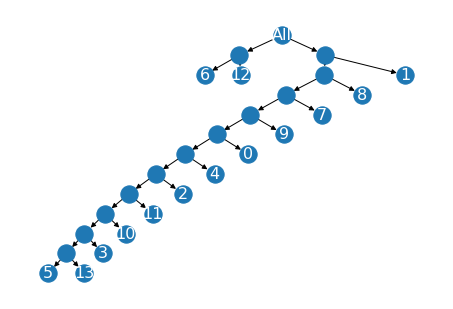

In [179]:
# pos = hierarchy_pos(G, 'All')
pos = graphviz_layout(G, prog='dot', root='All')
nx.draw(G, pos, with_labels=False, arrows=True)
labels = {}    
for node in G.nodes():
    if len(node.split('_'))==1:
        #set the node name as the key and the label as its value 
        labels[node] = node
nx.draw_networkx_labels(G, pos,labels, font_size=16, font_color='w')
plt.show()

In [187]:
names = G.nodes()
nodes = []
first_infs = []
second_infs = []
gt_infs = []
fractionRows = []
accs = []
losses = []
for node in names:
    if node != 'All':
        info = record_pool[node]
        nodes.append(node)
        gt_infs.append(info[0])
        first_infs.append(info[1])
        second_infs.append(info[2])
        accs.append(info[5])
        losses.append(info[6])

        cluster_ids = node.split('_')
        idxs = X_train_orig[X_train_orig['cluster']==int(cluster_ids[0])].index
        if len(cluster_ids) > 1:
            for cluster_id in cluster_ids:
                idxs = idxs.union(X_train_orig[X_train_orig['cluster']==int(cluster_id)].index)
        fractionRows.append(len(idxs)/len(X_train_orig))

In [188]:
expl = [nodes, first_infs, second_infs, gt_infs, fractionRows, accs, losses]
expl = (np.array(expl).T).tolist()
explanations = pd.DataFrame(expl, columns=["node", "first_order_influences", "second_order_influences", "gt_influences", "fractionRows", "accuracies", "losses"])

In [189]:
explanations.sort_values(by=['second_order_influences'], ascending=False)

,node,first_order_influences,second_order_influences,gt_influences,fractionRows,accuracies,losses
25,5_13_3_10_11_2_4_0_9_7_8_1,-0.009760248612928244,0.15479643919627506,-0.08780220348016876,0.90625,0.605,0.89788306
24,5_13_3_10_11_2_4_0_9_7_8,-0.014045259214035672,0.08437524035198862,-0.08836673092737335,0.87625,0.66,0.65509737
18,5_13_3_10_11,0.027225482803530956,0.047468610936527794,0.048989156167954184,0.34375,0.725,0.5425491
20,5_13_3_10_11_2_4,0.016896012532419284,0.045226525227833596,0.037782588764093905,0.51125,0.73,0.5312014
19,5_13_3_10_11_2,0.016368628086441735,0.03991726050392913,0.035731859074439876,0.4325,0.735,0.5342085
21,5_13_3_10_11_2_4_0,0.011660089569062596,0.03929981009091382,0.027224368881434202,0.595,0.72,0.5282197
22,5_13_3_10_11_2_4_0_9,-0.0038578076850527285,0.0381184983305336,0.055505985616036924,0.68125,0.7,0.60578763
23,5_13_3_10_11_2_4_0_9_7,-0.007225094127326564,0.03682765743209515,-0.025475817844926474,0.82,0.73,0.71182895
15,5_13_3,0.015688910337428662,0.02739599983147159,0.02646997955162078,0.28875,0.73,0.542212
14,5_13,0.015440875314100008,0.02710307095078867,0.024458893784321867,0.27625,0.74,0.53787196


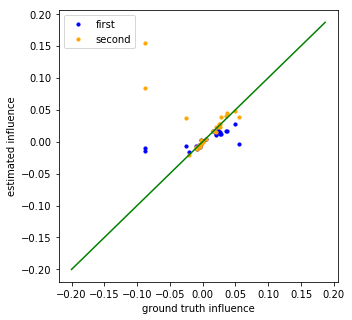

In [190]:
plt.figure(figsize=(5,5))
xs = (np.arange(30)-15)/15*0.2
ys = xs
# plt.xlim(-0.06, 0.04)
# plt.ylim(-0.03, 0.03)
plt.plot(xs, ys, 'g')
plt.scatter(gt_infs, first_infs, s=10, c='blue', label='first')
plt.scatter(gt_infs, second_infs, s=10, c='orange', label='second')
plt.xlabel('ground truth influence')
plt.ylabel('estimated influence')
plt.legend()

In [191]:
deviation = np.abs(np.array(second_infs)-np.array(gt_infs))
outliers = dict()
for node_idx, node in enumerate(nodes):
    # outliers
    if deviation[node_idx] > 0.03:
        outliers[node] = node

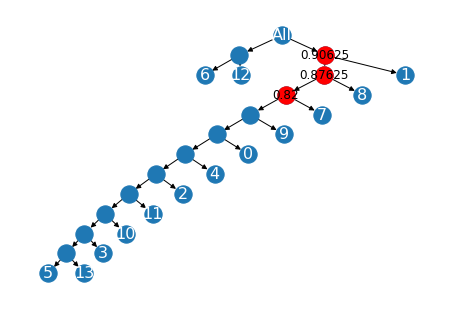

In [192]:
pos = graphviz_layout(G, prog='dot', root='All')
nx.draw(G, pos, with_labels=False, arrows=True)
labels = dict() 
for node in G.nodes():
    if len(node.split('_'))==1:
        #set the node name as the key and the label as its value 
        labels[node] = node
nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color='w')

outlier_labels = dict() 
for node_idx, node in list(enumerate(G.nodes()))[:-1]:
    if node in outliers:
        #set the node name as the key and the label as its value 
        outlier_labels[node] = fractionRows[node_idx]
nx.draw_networkx_nodes(G, pos, outliers, node_color='r')
nx.draw_networkx_labels(G, pos, outlier_labels, font_color='black')
plt.show()

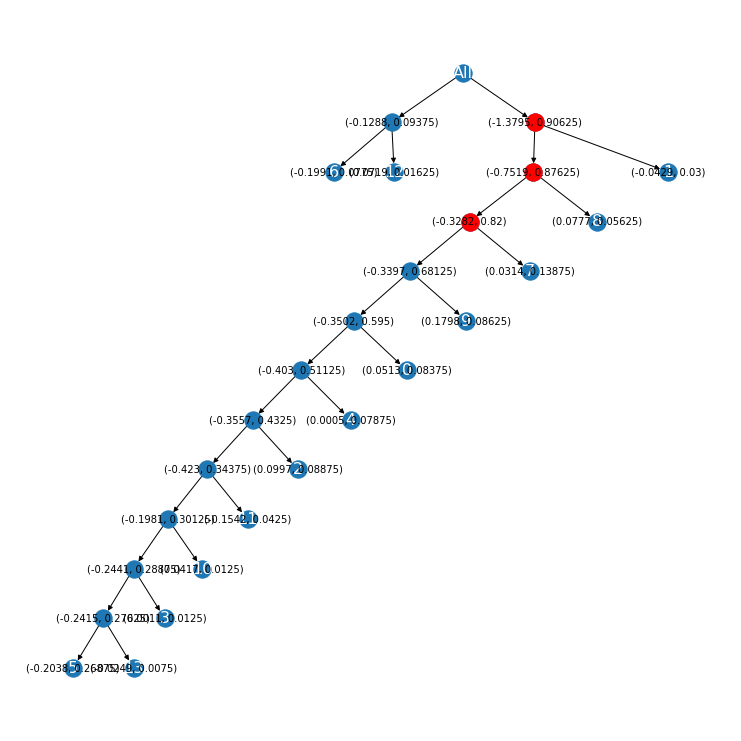

In [193]:
# show bias reduction
plt.figure(figsize=(10,10))
pos = graphviz_layout(G, prog='dot', root='All')
nx.draw(G, pos, with_labels=False, arrows=True)
labels = dict() 
for node in G.nodes():
    if len(node.split('_'))==1:
        #set the node name as the key and the label as its value 
        labels[node] = node
nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color='w')

bias_reduction_fraction_labels = dict() 
for node_idx, node in list(enumerate(G.nodes()))[:-1]:
    bias_reduction_fraction_labels[node] = (round(second_infs[node_idx]/spd_0,4), fractionRows[node_idx])
nx.draw_networkx_nodes(G, pos, outliers, node_color='r')
nx.draw_networkx_labels(G, pos, bias_reduction_fraction_labels, font_color='black', font_size=10)
plt.show()

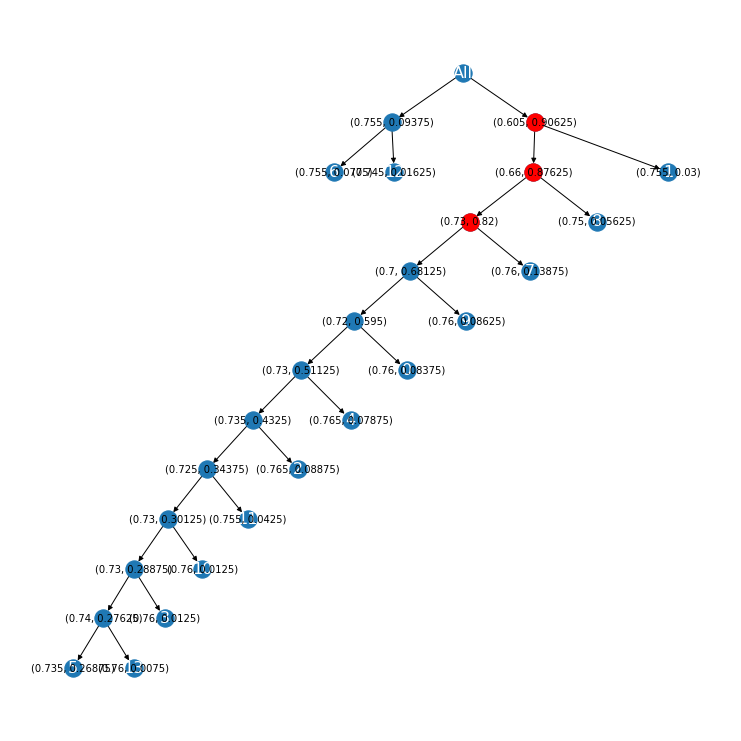

In [196]:
# show acc
plt.figure(figsize=(10,10))
pos = graphviz_layout(G, prog='dot', root='All')
nx.draw(G, pos, with_labels=False, arrows=True)
labels = dict() 
for node in G.nodes():
    if len(node.split('_'))==1:
        #set the node name as the key and the label as its value 
        labels[node] = node
nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color='w')

acc_labels = dict() 
for node_idx, node in list(enumerate(G.nodes()))[:-1]:
    acc_labels[node] = (accs[node_idx], fractionRows[node_idx])
nx.draw_networkx_nodes(G, pos, outliers, node_color='r')
nx.draw_networkx_labels(G, pos, acc_labels, font_color='black', font_size=10)
plt.show()

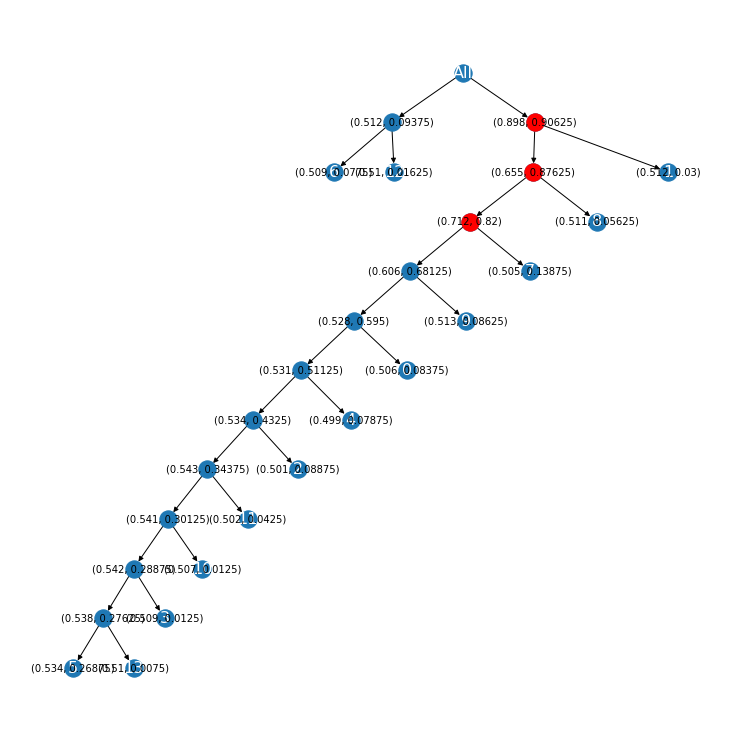

In [202]:
# show loss
plt.figure(figsize=(10,10))
pos = graphviz_layout(G, prog='dot', root='All')
nx.draw(G, pos, with_labels=False, arrows=True)
labels = dict() 
for node in G.nodes():
    if len(node.split('_'))==1:
        #set the node name as the key and the label as its value 
        labels[node] = node
nx.draw_networkx_labels(G, pos, labels, font_size=16, font_color='w')

loss_labels = dict() 
for node_idx, node in list(enumerate(G.nodes()))[:-1]:
    loss_labels[node] = (round(float(losses[node_idx]), 3), fractionRows[node_idx])
nx.draw_networkx_nodes(G, pos, outliers, node_color='r')
nx.draw_networkx_labels(G, pos, loss_labels, font_color='black', font_size=10)
plt.show()